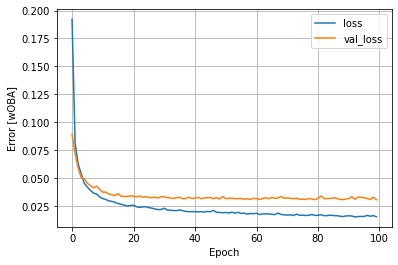

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# from baseball savant, parse out the pitcher csv file downloaded.

pitching_stats = pd.read_csv('../../datasets/baseball savant/pitching stats.csv').dropna()
hitting_stats = pd.read_csv('../../datasets/baseball savant/hitting stats.csv')

# remove unnamed columns then rows with nan
hitting_stats = hitting_stats.dropna(how='all', axis='columns').dropna()

# we need to derive ALOT of normalized variables, each w.r.t. the amount of PA's

percent_cols = [col for col in hitting_stats.columns if 'percent' in col]

# percents that are actually already in decimal: slg%, ob%, so just fix everything else.

percent_cols = [col for col in percent_cols if col not in ['slg_percent', 'on_base_percent']]

# add in barrel_batted_rate as well
percent_cols.append('barrel_batted_rate')

hitting_stats[percent_cols] = hitting_stats[percent_cols].apply(lambda x: x/100)

# what avg's are we working with (yeah i could just look at the csv, but that shit makes me dizzy)

avg_cols = [col for col in hitting_stats.columns if 'avg' in col and 'batting_avg' not in col]

# define our predictor variable, which is runs/PA

hitting_stats['runs/PA'] =  hitting_stats['r_run'] / hitting_stats['b_total_pa']

# define the set of features we want to model for.

# features = ['b_k_percent', 'b_bb_percent', 'exit_velocity_avg', 'launch_angle_avg', 'sweet_spot_percent', 'barrel_batted_rate', 'solidcontact_percent',
#             'flareburner_percent', 'poorlyunder_percent', 'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent', 'z_swing_percent',
#             'z_swing_miss_percent', 'oz_swing_percent','oz_swing_miss_percent', 'oz_contact_percent', 'meatball_swing_percent', 'iz_contact_percent',
#             'whiff_percent', 'swing_percent', 'pull_percent', 'straightaway_percent', 'opposite_percent', 'f_strike_percent', 'groundballs_percent', 
#             'flyballs_percent', 'linedrives_percent', 'popups_percent', 'sprint_speed', 'runs/PA']

features = ['b_k_percent', 'b_bb_percent', 'exit_velocity_avg', 'launch_angle_avg', 'solidcontact_percent',
            'sprint_speed','whiff_percent', 'oz_swing_percent','meatball_swing_percent','iz_contact_percent', 'linedrives_percent', 'woba']

dataset = hitting_stats[features]

train_dataset = dataset.sample(frac=0.9, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('woba')
test_labels = test_features.pop('woba')

# ok, normalize dis hoe (run me that z-score bruh).

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

def build_and_compile_model(norm):
  model = tf.keras.Sequential([
      norm,
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0005))
  return model

dnn_model = build_and_compile_model(normalizer)

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [wOBA]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

# test_predictions = dnn_model.predict(test_features).flatten()

# a = plt.axes(aspect='equal')
# plt.scatter(test_labels, test_predictions)
# plt.xlabel('True Values (runs/PA)')
# plt.ylabel('Predictions (runs/PA)')